In [17]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path

import numpy as np
import scipy
from scipy.spatial import cKDTree

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

import skimage as ski

In [18]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

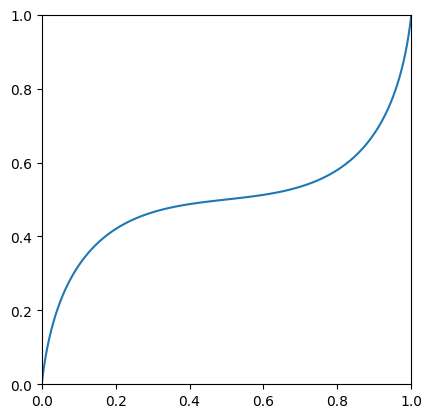

In [19]:
#Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])

Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T

plt.plot(bx,by)
ax = plt.gca()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect('equal')

In [20]:
radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.9 s, sys: 63.3 ms, total: 3.96 s
Wall time: 4.27 s
CPU times: user 18.1 s, sys: 217 ms, total: 18.4 s
Wall time: 19.5 s


In [21]:
#points = np.array([[0.5, 0.5], [0.25, 0.25], [0.75, 0.25], [0.20, 0.5], [0.80, 0.5], [0.25, 0.75], [0.75, 0.75]])
#tangents = np.array([[2, 0], [(-1), (-1)], [(-1), 1], [(-1), 0], [1,1], [0,1], [1, 0]])

In [22]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

In [23]:
#N = 512
#If, Tf = gs.patch.generate_image(points, tangents, N=N, pfunc=pfunc)

#I = If

#Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

#plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

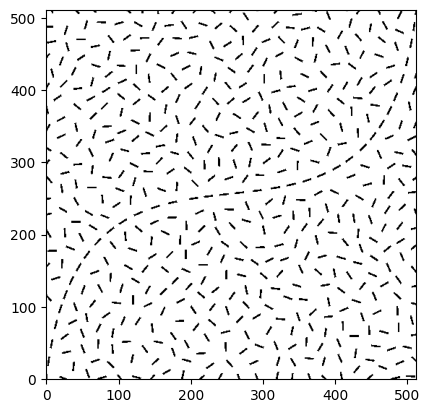

In [24]:
N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

In [25]:
def closest_neighbours(points, tangents, i):
    """
    Find the nearest neighbouring points and their tangents for a given point.

    Parameters
    points : (n, d) ndarray
        Array of n points in d-dimensional space.
    tangents : (n, d) ndarray
        Array of tangent vectors corresponding to each point.
    i : int
        Index of the reference point.

    Returns
    spoint : (d,) ndarray 
        The reference point at index `i`.
    norm_stang : (d,) ndarray
        Normalized tangent vector of the reference point.
    closest_points : (k-1, d) ndarray
        Coordinates of the k-1 nearest neighbours (excluding the point itself).
    norm_tang : (k-1, d) ndarray
        Normalized tangent vectors of the neighbouring points.
    """
    tree = cKDTree(points)
    # Reference point and normalized tangent
    spoint = points[i]
    norm_stang = tangents[i] / np.linalg.norm(tangents[i])

    # Query 7 neighbors, drop the point itself
    dists, idxs = tree.query(spoint, k= 11)
    dists, idxs = dists[1:], idxs[1:]

    # Select neighbors
    closest_points = points[idxs]
    closest_tang   = tangents[idxs]

    # Normalize tangents as a 2D array
    norm_tang = closest_tang / np.linalg.norm(closest_tang, axis=1, keepdims=True) 

    # Dot products as a clean NumPy array
    #dots = norm_tang @ stang_norm

    return spoint, norm_stang, closest_points, norm_tang

In [26]:
def problem_score(points, ref_point, tangents, ref_tangent):
    # Vector between two sets of points
    shift = points - ref_point   # shape (n, d)

    # Normalize the vectors (row-wise)
    norms = np.linalg.norm(shift, axis=1, keepdims=True)  # shape (n, 1)
    norm_shift = shift / np.where(norms == 0, 1, norms)            # avoid division by zero

    # Compute dot products
    sdot = norm_shift @ ref_tangent                        # (n,) assuming stang is shape (d,)
    cdot = np.einsum("ij,ij->i", norm_shift, tangents)   # (n,) assuming tang is shape (n, d)

    # Similarity measure
    sim = np.abs(sdot * cdot)

    dist_cor = 10 / (9 + np.exp(5 * ((norms / 0.05)-1)))
    dist_cor = dist_cor.ravel()
    problem_score = sim * dist_cor
    
    result = [ref_point, ref_tangent, points, problem_score]
    result_lists = [arr.tolist() for arr in result]
    
    return result_lists


In [27]:
points = D       # coordinates (N, 2)
tangents = Tg      # tangent vectors (N, 2)

#points = np.array([[0.5, 0.5], [0.25, 0.25], [0.75, 0.25], [0.20, 0.5], [0.80, 0.5], [0.25, 0.75], [0.75, 0.75]])
#tangents = np.array([[2, 0], [(-1), (-1)], [(-1), 1], [(-1), 0], [1,1], [0,1], [1, 0]])



In [28]:
print("# streepjes met te hoge probleemscore.")
for a in range(20):
    ratings = []
    problems = []
    for b in range(len(points)):
        r, rt, p, pt = closest_neighbours(points, tangents, b)
        rating = problem_score(p, r, pt, rt)
        ratings.append(rating)
        for ps in rating[3]:
            if ps > 0.8:
                problems.append(b)

    for c in problems:
        tangents[c][0] = tangents[c][0] + np.random.uniform(-1, 1)
        tangents[c][1] = tangents[c][1] + np.random.uniform(-1, 1)
    print(len(problems))

print(len(points))

# streepjes met te hoge probleemscore.
352
278
254
220
198
194
190
158
156
148
136
120
102
104
94
84
76
72
74
72
509


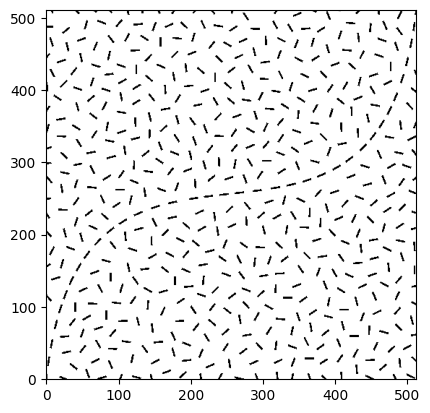

In [29]:
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(points, tangents, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

In [30]:
def select_points(points, tan, mask, target, max_points=2):
    """
    Select points and tangents based on a boolean mask.
    If more than max_points, keep only the closest to the target.
    """
    selected_points = points[mask]
    selected_tan = tan[mask]

    if selected_points.shape[0] > max_points:
        distances = np.linalg.norm(selected_points - target, axis=1)
        closest_indices = np.argsort(distances)[:max_points]
        selected_points = selected_points[closest_indices]
        selected_tan = selected_tan[closest_indices]
    
    return selected_points, selected_tan

def is_aligned(q):
    if len(q[0]) != 2:
        return False
    dot_product = abs(np.dot(q[1][0], q[1][1]))
    return dot_product > 0.75

def find_relevant_neighbours(target, target_tan, points, tan, threshold=0.9):
    """
    Find points and tangents whose direction from the target aligns with target_tan.
    If more than 2 points are relevant, keep only the 2 closest points to the target.

    Parameters:
    - target: array-like, shape (d,)
    - target_tan: array-like, shape (d,), assumed normalized
    - points: array-like, shape (n, d)
    - tan: array-like, shape (n, d)
    - threshold: float, minimum cosine similarity

    Returns:
    - points_relevant: array of points within threshold (up to 2 closest)
    - tan_relevant: array of corresponding tangents
    """
    # Vector from target to points
    diff = points - target  # shape (n, d)
    
    # Normalize vectors safely
    norms = np.linalg.norm(diff, axis=1, keepdims=True)
    diff_normalized = diff / np.where(norms == 0, 1, norms)
    
    # Cosine similarity with target tangent
    dots = np.abs(diff_normalized @ target_tan)

    # Usage
    points_aligned, tan_aligned = select_points(points, tan, dots >= threshold, target)
    points_unaligned, tan_unaligned = select_points(points, tan, dots >= 1 - threshold, target)

    aligned = np.array([points_aligned, tan_aligned])
    unaligned = np.array([points_unaligned, tan_unaligned])
    
    return aligned, unaligned

def alignment(aligned, unaligned):
    """Check if either 'aligned' or 'unaligned' pairs are sufficiently unaligned."""
    
    return is_aligned(aligned) or is_aligned(unaligned)

In [31]:
print("# streepjes met teveel alignment.")
for i in range(20):
    zroblems = []
    for j in range(len(points)):
        t, tt, n, nt = closest_neighbours(points, tangents, j)
        par, per = find_relevant_neighbours(t, tt, n, nt)
        if alignment(par, per) == True:
            zroblems.append(j)

    for q in zroblems:
        tangents[q][0] = tangents[q][0] + np.random.uniform(-0.5, 0.5)
        tangents[q][1] = tangents[q][1] + np.random.uniform(-0.5, 0.5)
    print(len(zroblems))

print(len(points))

# streepjes met teveel alignment.
334
332
306
293
290
291
279
273
277
276
278
281
284
279
267
276
270
277
268
266
509


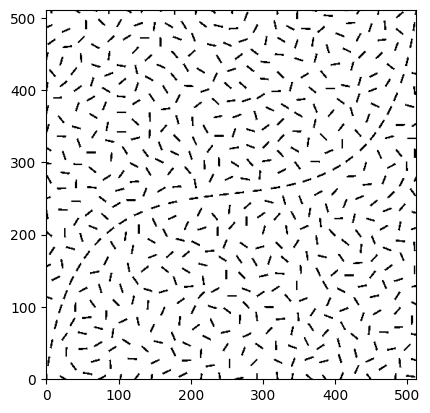

In [32]:
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(points, tangents, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')